答题卡区域提取与透视变换 - 增强可视化演示


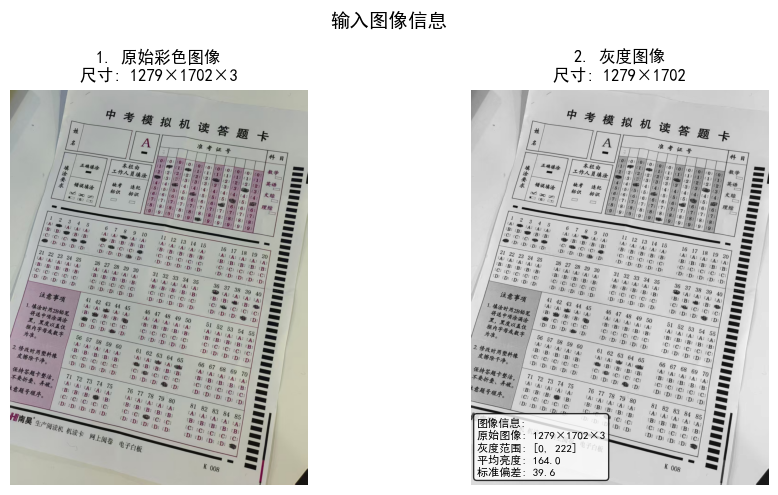

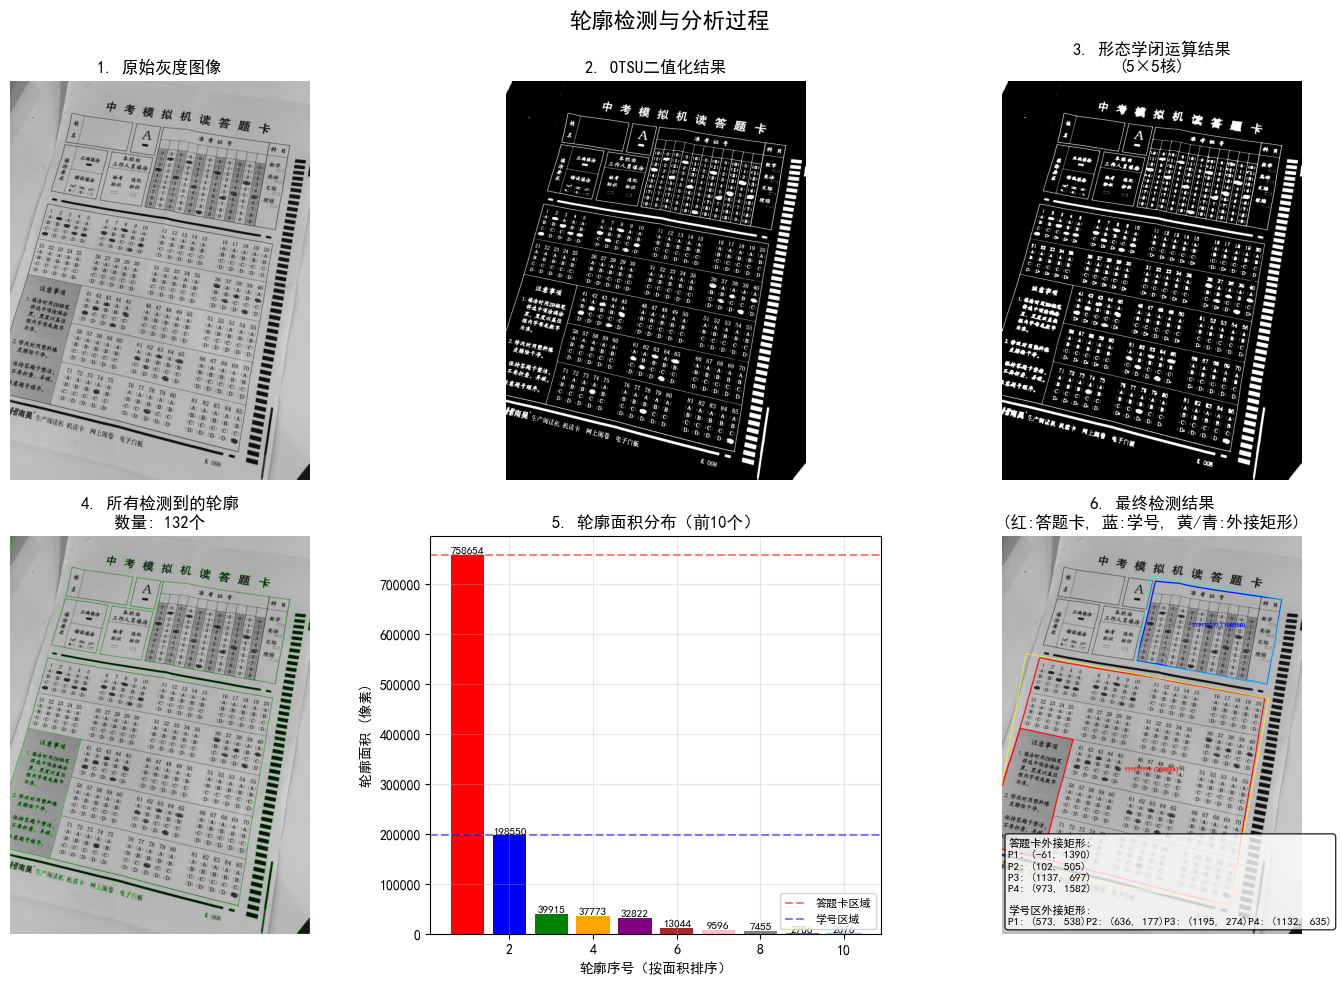

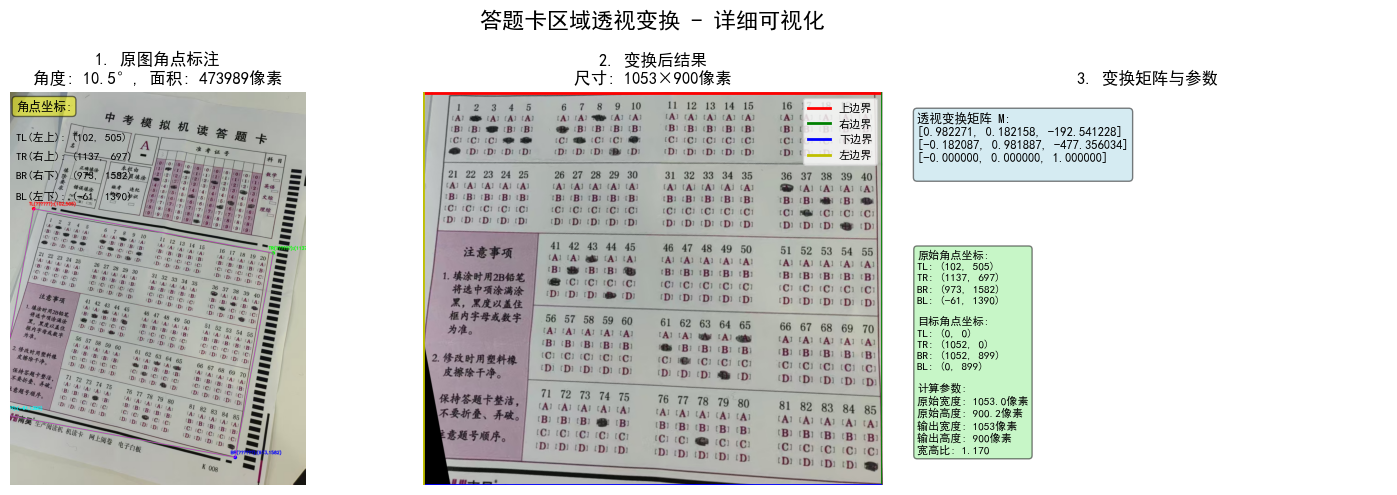

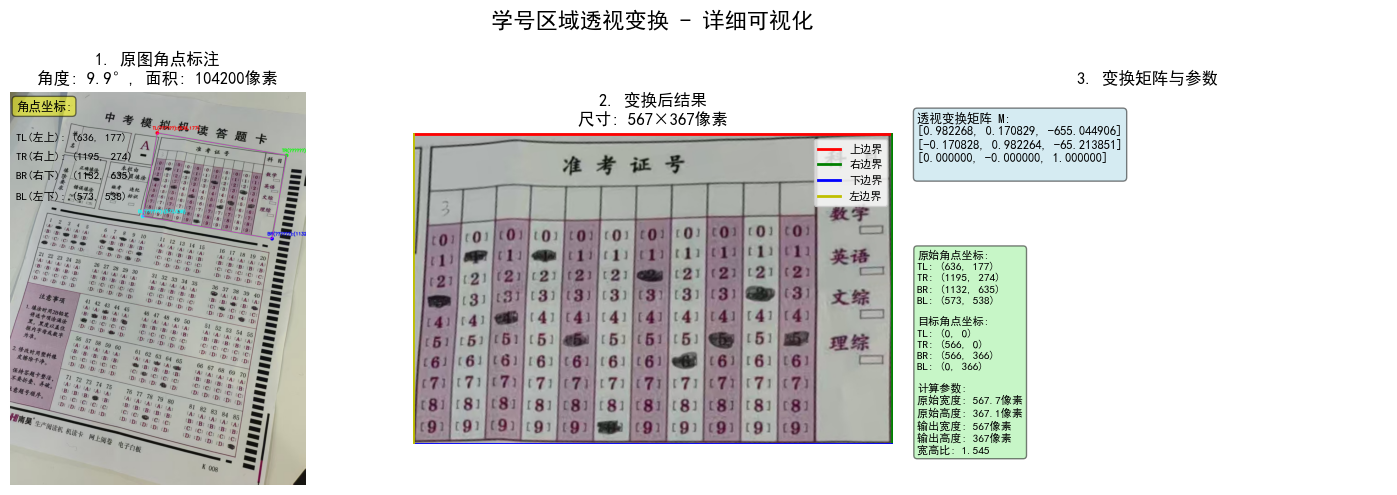

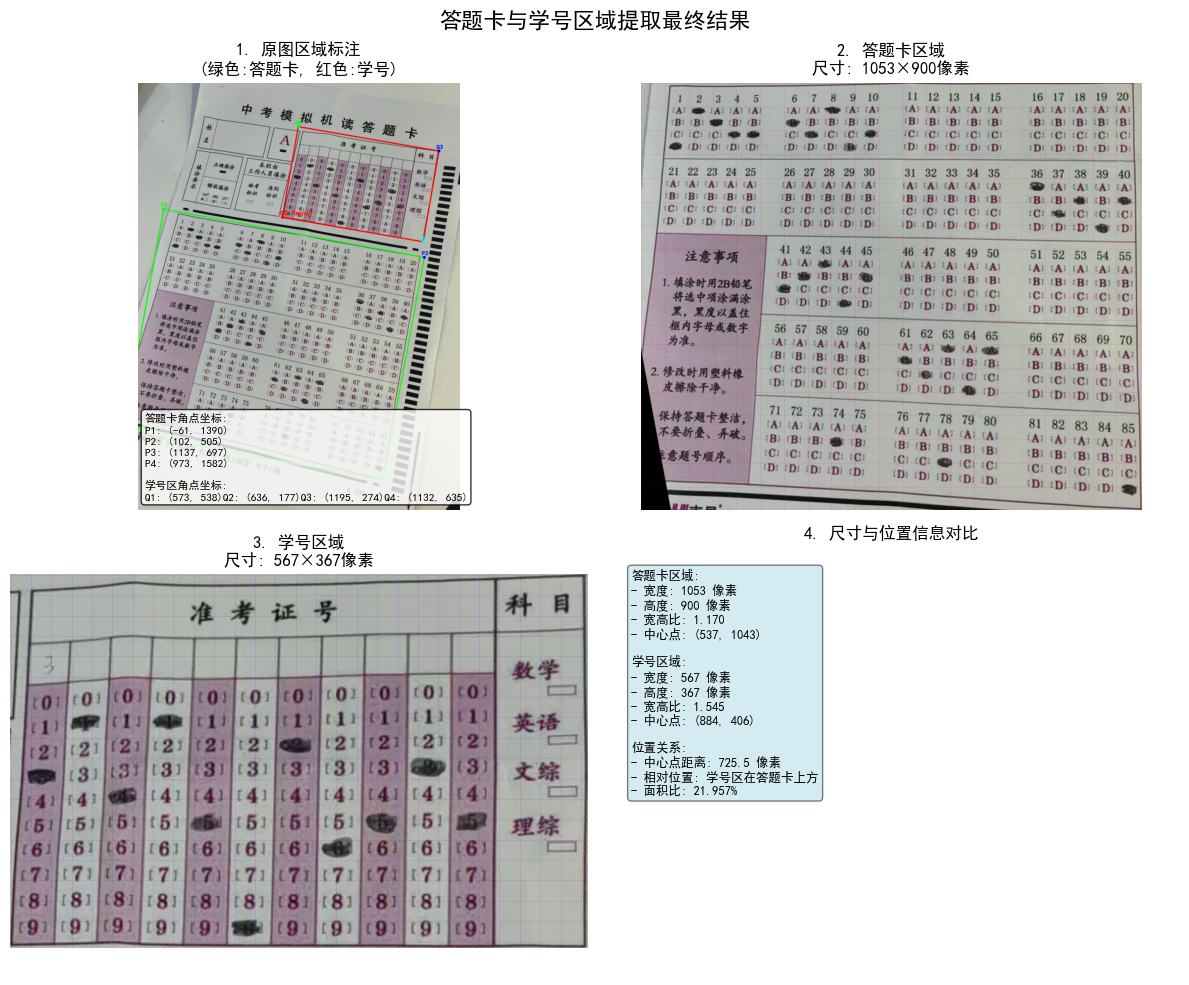


处理结果摘要:
1. 答题卡区域尺寸: 1053 × 900 像素
2. 学号区域尺寸: 567 × 367 像素
3. 答题卡原图角点坐标:
   点1: (-61, 1390)
   点2: (102, 505)
   点3: (1137, 697)
   点4: (973, 1582)
4. 学号区原图角点坐标:
   点1: (573, 538)
   点2: (636, 177)
   点3: (1195, 274)
   点4: (1132, 635)

处理完成！


In [9]:
'''
Step1: 提取答题区域和学号填涂区域，并透视变换转正视图
增强可视化版本 - 适合PPT演示
Author: 李明珠
Time: 2025-12-18
'''
import cv2
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, Optional, List

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False


def order_points(pts: np.ndarray) -> np.ndarray:
    """func:排序角点"""
    rect = np.zeros((4, 2), dtype="float32")
    sum_vals = pts.sum(axis=1)
    rect[0] = pts[np.argmin(sum_vals)]  # 左上：x+y最小
    rect[2] = pts[np.argmax(sum_vals)]  # 右下：x+y最大
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # 右上：x-y最小
    rect[3] = pts[np.argmax(diff)]  # 左下：x-y最大
    
    return rect

def visualize_perspective_transform(img: np.ndarray, corners: np.ndarray, 
                                   warped: np.ndarray, M: np.ndarray, 
                                   title: str = "透视变换") -> None:
    """可视化透视变换过程，包括角点标注和变换矩阵"""
    pts = corners.reshape(4, 2)
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'{title} - 详细可视化', fontsize=16, fontweight='bold')
    
    # 子图1: 原图标记角点和边界
    img_with_corners = img.copy() if len(img.shape) == 3 else cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    
    # 绘制边界框
    corners_int = corners.astype(np.int32)
    cv2.polylines(img_with_corners, [corners_int], True, (0, 255, 0), 3)
    
    # 标记角点
    colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (255, 255, 0)]  # 红、绿、蓝、黄
    labels = ['TL(左上)', 'TR(右上)', 'BR(右下)', 'BL(左下)']
    for i, (point, color, label) in enumerate(zip(rect, colors, labels)):
        x, y = int(point[0]), int(point[1])
        cv2.circle(img_with_corners, (x, y), 8, color, -1)
        cv2.putText(img_with_corners, f'{label}:({x},{y})', (x-20, y-15), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    # 绘制边界线
    cv2.line(img_with_corners, (int(tl[0]), int(tl[1])), (int(tr[0]), int(tr[1])), (255, 0, 255), 2)
    cv2.line(img_with_corners, (int(tr[0]), int(tr[1])), (int(br[0]), int(br[1])), (255, 0, 255), 2)
    cv2.line(img_with_corners, (int(br[0]), int(br[1])), (int(bl[0]), int(bl[1])), (255, 0, 255), 2)
    cv2.line(img_with_corners, (int(bl[0]), int(bl[1])), (int(tl[0]), int(tl[1])), (255, 0, 255), 2)
    
    # 计算和显示角度
    vector1 = np.array(tr) - np.array(tl)
    vector2 = np.array(br) - np.array(tr)
    angle = np.degrees(np.arctan2(vector1[1], vector1[0]))
    
    # 计算面积
    area = 0.5 * abs(np.cross(vector1, vector2))
    
    # 显示原图
    if len(img_with_corners.shape) == 2:
        axes[0].imshow(img_with_corners, cmap='gray')
    else:
        axes[0].imshow(cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB))
    axes[0].set_title(f'1. 原图角点标注\n角度: {abs(angle):.1f}°, 面积: {area:.0f}像素')
    axes[0].axis('off')
    
    # 在图中添加信息文本
    axes[0].text(0.02, 0.98, f'角点坐标:', transform=axes[0].transAxes, 
                 fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    for i, (point, label) in enumerate(zip(rect, labels)):
        axes[0].text(0.02, 0.90 - i*0.05, f'{label}: ({int(point[0])}, {int(point[1])})', 
                    transform=axes[0].transAxes, fontsize=8, verticalalignment='top')
    
    # 子图2: 透视变换结果
    if len(warped.shape) == 2:
        axes[1].imshow(warped, cmap='gray')
    else:
        axes[1].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
    axes[1].set_title(f'2. 变换后结果\n尺寸: {warped.shape[1]}×{warped.shape[0]}像素')
    axes[1].axis('off')
    
    # 标记变换后图像的关键点
    axes[1].plot([0, warped.shape[1]-1], [0, 0], 'r-', linewidth=2, label='上边界')
    axes[1].plot([warped.shape[1]-1, warped.shape[1]-1], [0, warped.shape[0]-1], 'g-', linewidth=2, label='右边界')
    axes[1].plot([warped.shape[1]-1, 0], [warped.shape[0]-1, warped.shape[0]-1], 'b-', linewidth=2, label='下边界')
    axes[1].plot([0, 0], [warped.shape[0]-1, 0], 'y-', linewidth=2, label='左边界')
    axes[1].legend(loc='upper right', fontsize=8)
    
    # 子图3: 变换矩阵和计算信息
    axes[2].axis('off')
    axes[2].set_title('3. 变换矩阵与参数')
    
    # 显示变换矩阵
    matrix_text = "透视变换矩阵 M:\n"
    for i in range(3):
        matrix_text += f"[{M[i,0]:.6f}, {M[i,1]:.6f}, {M[i,2]:.6f}]\n"
    
    # 计算目标点
    dst_corners = np.array([[0, 0], 
                           [warped.shape[1]-1, 0], 
                           [warped.shape[1]-1, warped.shape[0]-1], 
                           [0, warped.shape[0]-1]], dtype=np.float32)
    
    # 计算宽高
    width = np.linalg.norm(tr - tl)
    height = np.linalg.norm(bl - tl)
    
    info_text = f'''原始角点坐标:
TL: ({int(tl[0])}, {int(tl[1])})
TR: ({int(tr[0])}, {int(tr[1])})
BR: ({int(br[0])}, {int(br[1])})
BL: ({int(bl[0])}, {int(bl[1])})

目标角点坐标:
TL: ({int(dst_corners[0,0])}, {int(dst_corners[0,1])})
TR: ({int(dst_corners[1,0])}, {int(dst_corners[1,1])})
BR: ({int(dst_corners[2,0])}, {int(dst_corners[2,1])})
BL: ({int(dst_corners[3,0])}, {int(dst_corners[3,1])})

计算参数:
原始宽度: {width:.1f}像素
原始高度: {height:.1f}像素
输出宽度: {warped.shape[1]}像素
输出高度: {warped.shape[0]}像素
宽高比: {warped.shape[1]/warped.shape[0]:.3f}'''
    
    axes[2].text(0.02, 0.95, matrix_text, transform=axes[2].transAxes, 
                fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    axes[2].text(0.02, 0.60, info_text, transform=axes[2].transAxes, 
                fontsize=8, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

def perspective_transform(img, corners, show=False, title="透视变换"):
    """func:对指定区域进行透视变换，转为正视图"""
    pts = corners.reshape(4, 2)
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # 计算新图像宽高
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # 目标矩形的四个角点（正视图）
    dst = np.array([
        [0, 0],                    # 左上
        [maxWidth - 1, 0],         # 右上
        [maxWidth - 1, maxHeight - 1],  # 右下
        [0, maxHeight - 1]         # 左下
    ], dtype="float32")
    
    # 计算透视变换矩阵
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
    
    if show:
        visualize_perspective_transform(img, corners, warped, M, title)
    
    return warped, M

def visualize_contour_analysis(img_gray: np.ndarray, binary: np.ndarray, closed: np.ndarray, 
                              contours: List, ans_box: np.ndarray, id_box: np.ndarray) -> None:
    """可视化轮廓分析过程，适合PPT展示"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle('轮廓检测与分析过程', fontsize=16, fontweight='bold', y=0.98)
    
    # 子图1: 原始灰度图像
    axes[0, 0].imshow(img_gray, cmap='gray', vmin=0, vmax=255)
    axes[0, 0].set_title('1. 原始灰度图像')
    axes[0, 0].axis('off')
    
    # 子图2: 二值化结果
    axes[0, 1].imshow(binary, cmap='gray')
    axes[0, 1].set_title('2. OTSU二值化结果')
    axes[0, 1].axis('off')
    
    # 计算二值化统计
    white_pixels = np.sum(binary == 255)
    black_pixels = np.sum(binary == 0)
    total_pixels = binary.size
    white_ratio = white_pixels / total_pixels * 100
    
    # 子图3: 形态学闭运算
    axes[0, 2].imshow(closed, cmap='gray')
    axes[0, 2].set_title('3. 形态学闭运算结果\n(5×5核)')
    axes[0, 2].axis('off')
    
    # 子图4: 所有检测到的轮廓
    img_all_contours = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(img_all_contours, contours, -1, (0, 255, 0), 1)
    axes[1, 0].imshow(cv2.cvtColor(img_all_contours, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title(f'4. 所有检测到的轮廓\n数量: {len(contours)}个')
    axes[1, 0].axis('off')
    
    # 标注轮廓数量和面积范围
    if contours:
        areas = [cv2.contourArea(cnt) for cnt in contours]

    
    # 子图5: 轮廓面积分析
    if contours:
        # 按面积排序轮廓
        sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
        areas = [cv2.contourArea(cnt) for cnt in sorted_contours[:10]]  # 前10个最大面积
        indices = range(1, len(areas) + 1)
        
        bars = axes[1, 1].bar(indices, areas, color=['red', 'blue', 'green', 'orange', 'purple', 
                                                     'brown', 'pink', 'gray', 'olive', 'cyan'][:len(areas)])
        axes[1, 1].set_xlabel('轮廓序号（按面积排序）')
        axes[1, 1].set_ylabel('轮廓面积 (像素)')
        axes[1, 1].set_title('5. 轮廓面积分布（前10个）')
        axes[1, 1].grid(True, alpha=0.3)
        
        # 标注数值
        for i, (idx, area) in enumerate(zip(indices, areas)):
            axes[1, 1].text(idx, area, f'{area:.0f}', ha='center', va='bottom', fontsize=8)
        
        # 标注选中轮廓
        if len(areas) >= 2:
            axes[1, 1].axhline(y=areas[0], color='red', linestyle='--', alpha=0.5, label='答题卡区域')
            axes[1, 1].axhline(y=areas[1], color='blue', linestyle='--', alpha=0.5, label='学号区域')
            axes[1, 1].legend(fontsize=8)
    
    # 子图6: 最终检测结果
    img_final = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)
    
    # 绘制前2个最大轮廓
    if len(contours) >= 2:
        largest_contour = max(contours, key=cv2.contourArea)
        second_largest = sorted(contours, key=cv2.contourArea, reverse=True)[1]
        
        # 绘制轮廓
        cv2.drawContours(img_final, [largest_contour], -1, (0, 0, 255), 3)  # 红色：答题卡
        cv2.drawContours(img_final, [second_largest], -1, (255, 0, 0), 3)   # 蓝色：学号区
        
        # 绘制最小外接矩形
        ans_box_int = ans_box.astype(np.int32)
        cv2.polylines(img_final, [ans_box_int], True, (0, 255, 255), 2)  # 黄色框
        
        id_box_int = id_box.astype(np.int32)
        cv2.polylines(img_final, [id_box_int], True, (255, 255, 0), 2)  # 青色框
        
        # 添加标签
        M_ans = cv2.moments(largest_contour)
        if M_ans['m00'] != 0:
            cx_ans = int(M_ans['m10'] / M_ans['m00'])
            cy_ans = int(M_ans['m01'] / M_ans['m00'])
            cv2.putText(img_final, f'答题卡 ({cv2.contourArea(largest_contour):.0f})', 
                       (cx_ans-100, cy_ans-20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        M_id = cv2.moments(second_largest)
        if M_id['m00'] != 0:
            cx_id = int(M_id['m10'] / M_id['m00'])
            cy_id = int(M_id['m01'] / M_id['m00'])
            cv2.putText(img_final, f'学号区 ({cv2.contourArea(second_largest):.0f})', 
                       (cx_id-80, cy_id-20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
    
    axes[1, 2].imshow(cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB))
    axes[1, 2].set_title('6. 最终检测结果\n(红:答题卡, 蓝:学号, 黄/青:外接矩形)')
    axes[1, 2].axis('off')
    
    # 显示外接矩形坐标
    if 'ans_box_int' in locals() and 'id_box_int' in locals():
        coord_text = f"答题卡外接矩形:\n"
        for i, (x, y) in enumerate(ans_box_int):
            coord_text += f"P{i+1}: ({x}, {y})\n"
        coord_text += f"\n学号区外接矩形:\n"
        for i, (x, y) in enumerate(id_box_int):
            coord_text += f"P{i+1}: ({x}, {y})"
        
        axes[1, 2].text(0.02, 0.02, coord_text, transform=axes[1, 2].transAxes, 
                       fontsize=8, verticalalignment='bottom',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()

def find_answer_sheet_corners(img_gray, show=False):
    """func:找到答题区域和学号填涂区域的角点"""
    # Step 1: 二值化
    _, binary = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Step 2: 形态学闭运算
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    # Step 3: 查找轮廓
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 最大的轮廓是答题卡区域
    largest_contour = max(contours, key=cv2.contourArea)
    # 次大的轮廓是学号填涂区
    second_largest_contour = sorted(contours, key=cv2.contourArea, reverse=True)[1]
    
    # 使用最小外接矩形获取角点
    rect_ans = cv2.minAreaRect(largest_contour)
    ans_box = cv2.boxPoints(rect_ans).astype("float32")
    
    rect_id = cv2.minAreaRect(second_largest_contour)
    id_box = cv2.boxPoints(rect_id).astype("float32")
    
    if show:
        visualize_contour_analysis(img_gray, binary, closed, contours, ans_box, id_box)
    
    return ans_box, id_box, binary, closed, contours

def visualize_final_comparison(original_img: np.ndarray, 
                               sheet_warped: np.ndarray, 
                               id_region_warped: np.ndarray,
                               ans_box: np.ndarray,
                               id_box: np.ndarray) -> None:
    """可视化最终对比结果"""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle('答题卡与学号区域提取最终结果', fontsize=16, fontweight='bold', y=0.98)
    
    # 子图1: 原图标注
    img_marked = original_img.copy()
    
    # 绘制答题卡区域
    ans_box_int = ans_box.astype(np.int32)
    cv2.polylines(img_marked, [ans_box_int], True, (0, 255, 0), 3)
    cv2.putText(img_marked, "Answer Sheet", (ans_box_int[0][0], ans_box_int[0][1]-10), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)
    
    # 绘制学号区域
    id_box_int = id_box.astype(np.int32)
    cv2.polylines(img_marked, [id_box_int], True, (0, 0, 255), 3)
    cv2.putText(img_marked, "ID Region", (id_box_int[0][0], id_box_int[0][1]-10), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
    
    # 标记角点
    colors = [(0, 0, 255), (0, 255, 0), (255, 0, 0), (255, 255, 0)]
    labels = ['A', 'B', 'C', 'D']
    
    for i, (point, color) in enumerate(zip(ans_box_int, colors)):
        cv2.circle(img_marked, tuple(point), 6, color, -1)
        cv2.putText(img_marked, f'P{i+1}', (point[0]-10, point[1]-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    for i, (point, color) in enumerate(zip(id_box_int, colors)):
        cv2.circle(img_marked, tuple(point), 6, color, -1)
        cv2.putText(img_marked, f'Q{i+1}', (point[0]-10, point[1]-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    
    axes[0, 0].imshow(cv2.cvtColor(img_marked, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('1. 原图区域标注\n(绿色:答题卡, 红色:学号)')
    axes[0, 0].axis('off')
    
    # 显示坐标信息
    coord_text = "答题卡角点坐标:\n"
    for i, (x, y) in enumerate(ans_box_int):
        coord_text += f"P{i+1}: ({x}, {y})\n"
    coord_text += "\n学号区角点坐标:\n"
    for i, (x, y) in enumerate(id_box_int):
        coord_text += f"Q{i+1}: ({x}, {y})"
    
    axes[0, 0].text(0.02, 0.02, coord_text, transform=axes[0, 0].transAxes, 
                   fontsize=8, verticalalignment='bottom',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # 子图2: 答题卡变换结果
    if len(sheet_warped.shape) == 2:
        axes[0, 1].imshow(sheet_warped, cmap='gray')
    else:
        axes[0, 1].imshow(cv2.cvtColor(sheet_warped, cv2.COLOR_BGR2RGB))
    axes[0, 1].set_title(f'2. 答题卡区域\n尺寸: {sheet_warped.shape[1]}×{sheet_warped.shape[0]}像素')
    axes[0, 1].axis('off')
    
    # 绘制网格线
    h, w = sheet_warped.shape[:2]
    grid_spacing = 50
    for i in range(0, h, grid_spacing):
        axes[0, 1].axhline(y=i, color='red', alpha=0.1, linewidth=0.5)
    for j in range(0, w, grid_spacing):
        axes[0, 1].axvline(x=j, color='red', alpha=0.1, linewidth=0.5)
    
    # 子图3: 学号区域变换结果
    if len(id_region_warped.shape) == 2:
        axes[1, 0].imshow(id_region_warped, cmap='gray')
    else:
        axes[1, 0].imshow(cv2.cvtColor(id_region_warped, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title(f'3. 学号区域\n尺寸: {id_region_warped.shape[1]}×{id_region_warped.shape[0]}像素')
    axes[1, 0].axis('off')
    
    # 绘制网格线
    h_id, w_id = id_region_warped.shape[:2]
    grid_spacing_id = 20
    for i in range(0, h_id, grid_spacing_id):
        axes[1, 0].axhline(y=i, color='blue', alpha=0.1, linewidth=0.5)
    for j in range(0, w_id, grid_spacing_id):
        axes[1, 0].axvline(x=j, color='blue', alpha=0.1, linewidth=0.5)
    
    # 子图4: 尺寸和位置对比
    axes[1, 1].axis('off')
    axes[1, 1].set_title('4. 尺寸与位置信息对比')
    
    # 计算几何信息
    ans_center = np.mean(ans_box_int, axis=0)
    id_center = np.mean(id_box_int, axis=0)
    
    # 计算距离
    center_distance = np.linalg.norm(ans_center - id_center)
    
    info_text = f'''答题卡区域:
- 宽度: {w} 像素
- 高度: {h} 像素
- 宽高比: {w/h:.3f}
- 中心点: ({int(ans_center[0])}, {int(ans_center[1])})

学号区域:
- 宽度: {w_id} 像素
- 高度: {h_id} 像素
- 宽高比: {w_id/h_id:.3f}
- 中心点: ({int(id_center[0])}, {int(id_center[1])})

位置关系:
- 中心点距离: {center_distance:.1f} 像素
- 相对位置: 学号区在答题卡{'上方' if id_center[1] < ans_center[1] else '下方'}
- 面积比: {(w_id*h_id)/(w*h):.3%}'''

    axes[1, 1].text(0.05, 0.95, info_text, transform=axes[1, 1].transAxes, 
                   fontsize=9, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

def process_answer_sheet(image_path: str, show_steps: bool = True, show_transform: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """func:功能集合实现，增强可视化"""
    # 读取图像
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"无法读取图像: {image_path}")
    
    # 转换为灰度图
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 显示原图信息
    if show_steps:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        fig.suptitle('输入图像信息', fontsize=14, fontweight='bold')
        
        axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f'1. 原始彩色图像\n尺寸: {img.shape[1]}×{img.shape[0]}×{img.shape[2]}')
        axes[0].axis('off')
        
        axes[1].imshow(gray, cmap='gray')
        axes[1].set_title(f'2. 灰度图像\n尺寸: {gray.shape[1]}×{gray.shape[0]}')
        axes[1].axis('off')
        
        # 显示统计信息
        info_text = f'''图像信息:
原始图像: {img.shape[1]}×{img.shape[0]}×{img.shape[2]}
灰度范围: [{gray.min()}, {gray.max()}]
平均亮度: {gray.mean():.1f}
标准偏差: {gray.std():.1f}'''
        
        axes[1].text(0.02, 0.02, info_text, transform=axes[1].transAxes, 
                    fontsize=8, verticalalignment='bottom',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        plt.tight_layout()
        plt.show()
    
    # 查找角点
    ans_box, id_box, binary, closed, contours = find_answer_sheet_corners(gray, show=show_steps)
    
    # 透视变换
    sheet_warped, M_sheet = perspective_transform(img, ans_box, show=show_transform, title="答题卡区域透视变换")
    id_region_warped, M_id = perspective_transform(img, id_box, show=show_transform, title="学号区域透视变换")
    
    # 显示最终对比
    if show_steps:
        visualize_final_comparison(img, sheet_warped, id_region_warped, ans_box, id_box)
    
    return sheet_warped, id_region_warped, ans_box, id_box

# 主程序
if __name__ == "__main__":
    try:
        # 修改为你的图片路径
        image_path = '../images/test2.jpg'
        
        print("=" * 60)
        print("答题卡区域提取与透视变换 - 增强可视化演示")
        print("=" * 60)
        
        sheet_warped, id_region_warped, ans_box, id_box = process_answer_sheet(
            image_path, 
            show_steps=True,  # 显示处理步骤
            show_transform=True  # 显示变换过程
        )
        
        # 打印最终结果
        print("\n" + "=" * 60)
        print("处理结果摘要:")
        print("=" * 60)
        print(f"1. 答题卡区域尺寸: {sheet_warped.shape[1]} × {sheet_warped.shape[0]} 像素")
        print(f"2. 学号区域尺寸: {id_region_warped.shape[1]} × {id_region_warped.shape[0]} 像素")
        print(f"3. 答题卡原图角点坐标:")
        for i, point in enumerate(ans_box.astype(int)):
            print(f"   点{i+1}: ({point[0]}, {point[1]})")
        print(f"4. 学号区原图角点坐标:")
        for i, point in enumerate(id_box.astype(int)):
            print(f"   点{i+1}: ({point[0]}, {point[1]})")
        print("\n处理完成！")
        
    except FileNotFoundError as e:
        print(f"错误: {e}")
        print("请检查图片路径是否正确")
    except Exception as e:
        print(f"处理过程中发生错误: {e}")
        import traceback
        traceback.print_exc()

方法对比演示: 轮廓角点 vs 最小外接矩形


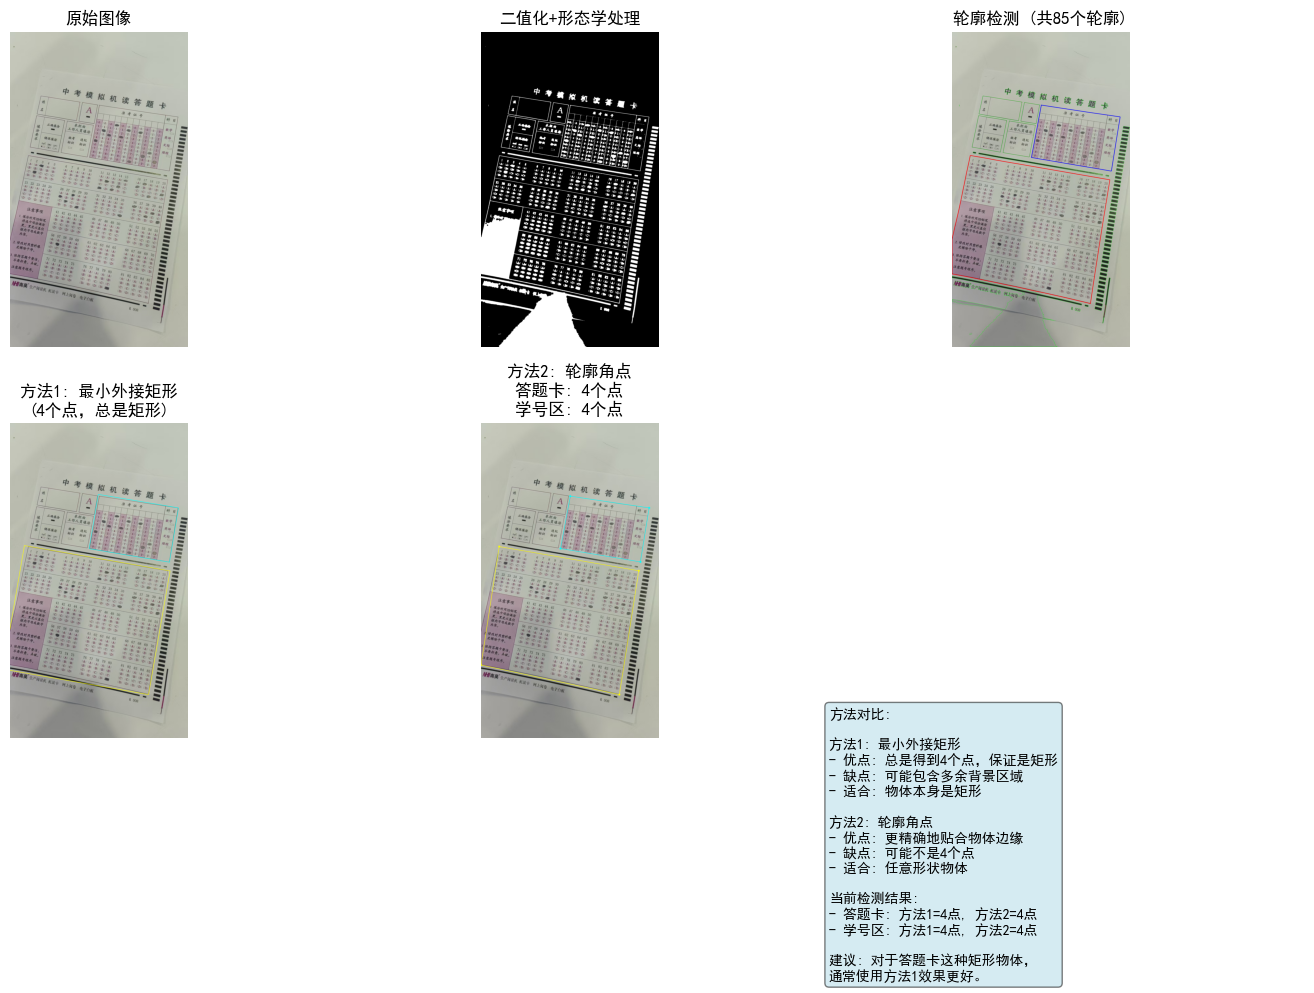


正在处理答题卡...


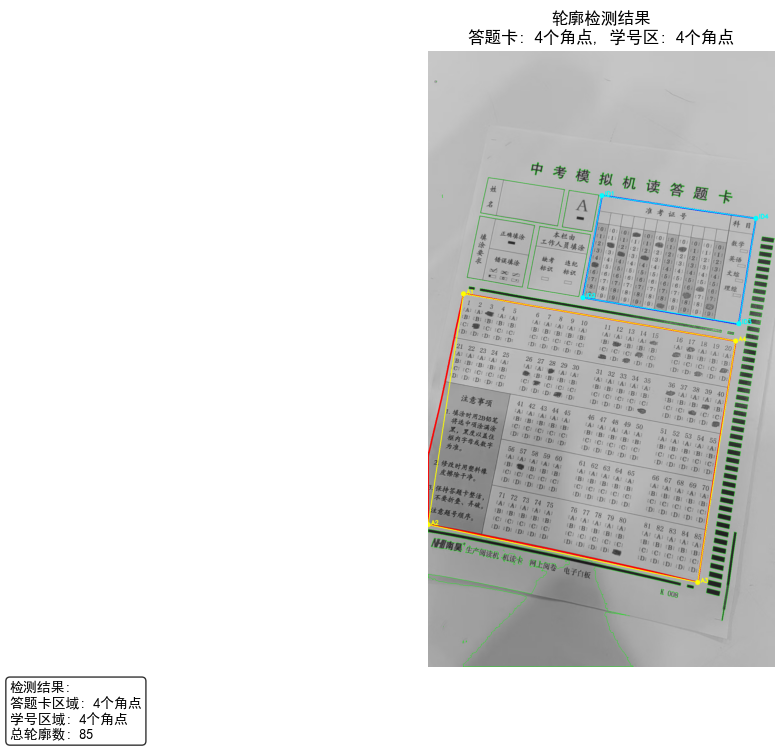

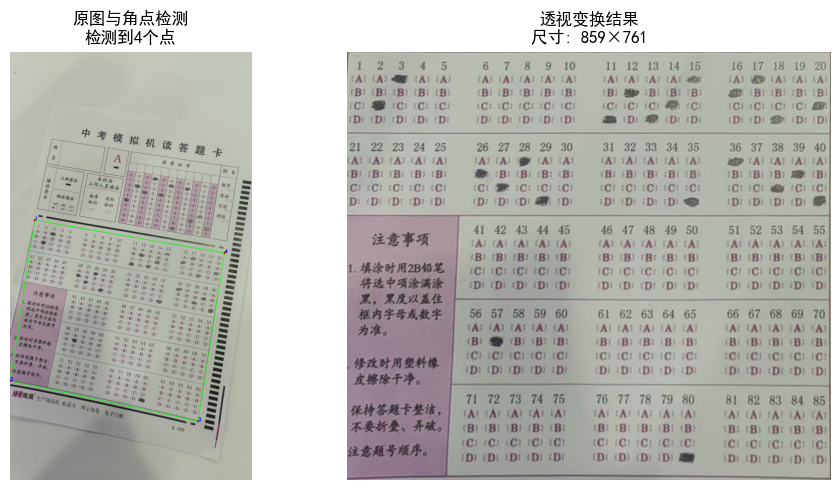

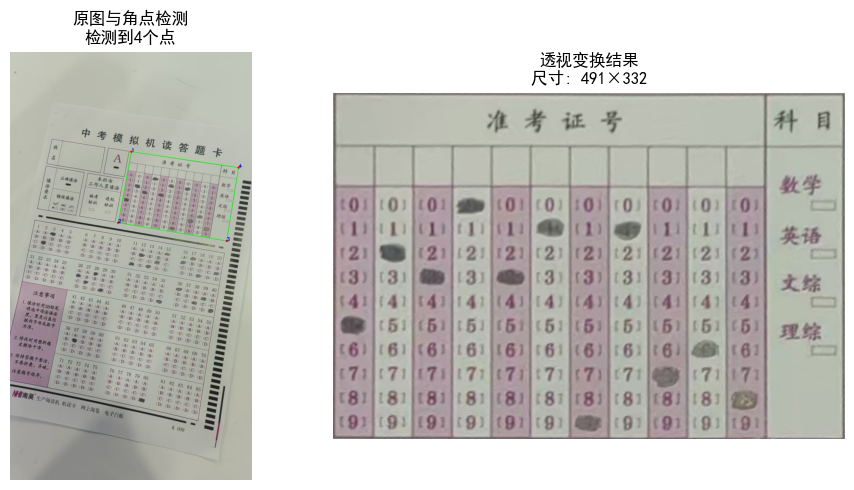

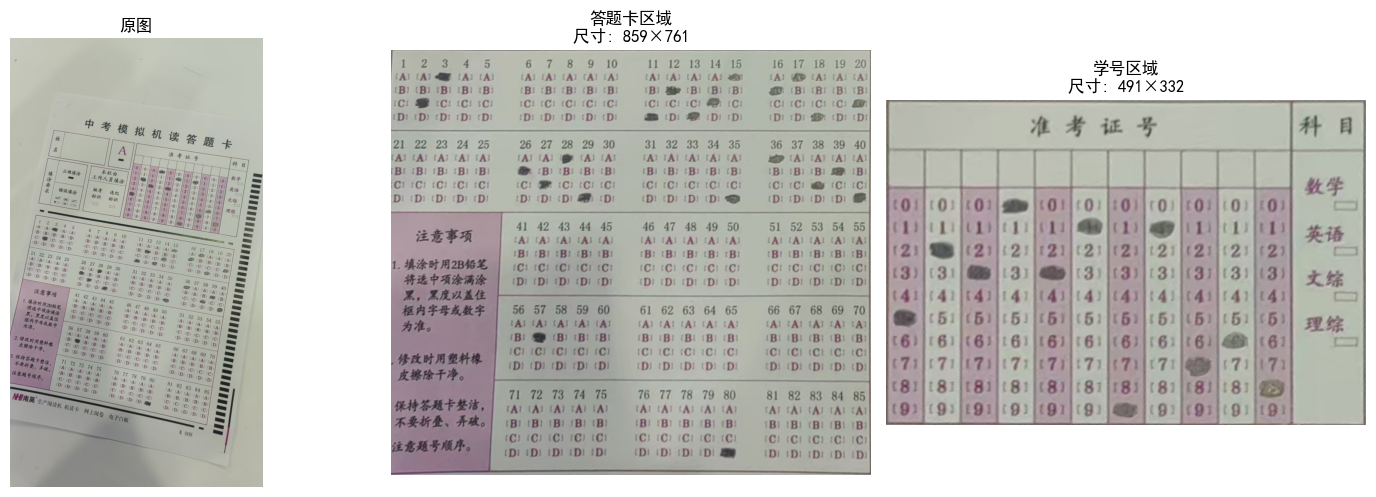


处理完成!
答题卡区域尺寸: 859 × 761
学号区域尺寸: 491 × 332
答题卡角点数: 4
学号区角点数: 4


In [20]:
'''
Step1: 提取答题区域和学号填涂区域，并透视变换转正视图
Author: 李明珠
Time: 2025-12-18
Modified: 改为使用轮廓角点
'''
import cv2
import numpy as np
import matplotlib.pyplot as plt

def order_points(pts):
    """func:排序角点"""
    rect = np.zeros((4, 2), dtype="float32")
    sum = pts.sum(axis=1)
    rect[0] = pts[np.argmin(sum)]  # 左上：x+y最小
    rect[2] = pts[np.argmax(sum)]  # 右下：x+y最大
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # 右上：x-y最小
    rect[3] = pts[np.argmax(diff)]  # 左下：x-y最大
    
    return rect

def perspective_transform(img, corners, show=False):
    """func:对指定区域进行透视变换，转为正视图"""
    # 确保是4个点
    if len(corners) != 4:
        print(f"警告: 期望4个角点，但得到{corners.shape}，将进行近似处理")
        # 如果点数过多，使用多边形近似
        if len(corners) > 4:
            # 计算轮廓周长
            epsilon = 0.02 * cv2.arcLength(corners.astype(np.float32), True)
            approx = cv2.approxPolyDP(corners.astype(np.float32), epsilon, True)
            corners = approx
    
    pts = corners.reshape(4, 2)
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # 计算新图像宽高
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # 目标矩形的四个角点（正视图）
    dst = np.array([
        [0, 0],                    # 左上
        [maxWidth - 1, 0],         # 右上
        [maxWidth - 1, maxHeight - 1],  # 右下
        [0, maxHeight - 1]         # 左下
    ], dtype="float32")
    
    # 计算透视变换矩阵
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
    
    if show:
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        
        # 显示原图与角点
        img_copy = img.copy()
        corners_int = corners.astype(np.int32)
        cv2.drawContours(img_copy, [corners_int], -1, (0, 255, 0), 2)
        for i, point in enumerate(corners_int):
            cv2.circle(img_copy, tuple(point[0]), 5, (0, 0, 255), -1)
            cv2.putText(img_copy, str(i+1), tuple(point[0]), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        
        axes[0].imshow(cv2.cvtColor(img_copy, cv2.COLOR_BGR2RGB))
        axes[0].set_title(f'原图与角点检测\n检测到{len(corners)}个点')
        axes[0].axis('off')
        
        # 显示变换结果
        if len(warped.shape) == 2:
            axes[1].imshow(warped, cmap='gray')
        else:
            axes[1].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f'透视变换结果\n尺寸: {maxWidth}×{maxHeight}')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()

    return warped, M

def find_answer_sheet_corners(img_gray, show=False):
    """func:找到答题区域和学号填涂区域的角点（使用轮廓角点）"""
    _, binary = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 最大的轮廓是答题卡区域
    largest_contour = max(contours, key=cv2.contourArea)
    # 次大的轮廓是学号填涂区
    second_largest_contour = sorted(contours, key=cv2.contourArea, reverse=True)[1]
    
    # 使用多边形近似获取轮廓的角点
    # 对于答题卡（应该是矩形），使用较小的epsilon
    epsilon_ans = 0.02 * cv2.arcLength(largest_contour, True)
    ans_corners = cv2.approxPolyDP(largest_contour, epsilon_ans, True)
    
    # 对于学号区，也使用多边形近似
    epsilon_id = 0.02 * cv2.arcLength(second_largest_contour, True)
    id_corners = cv2.approxPolyDP(second_largest_contour, epsilon_id, True)
    
    # 确保是4个点（对于矩形区域应该是4个点）
    if len(ans_corners) != 4:
        print(f"警告: 答题卡区域检测到{len(ans_corners)}个角点，期望4个")
        # 如果不是4个点，使用凸包然后取关键点
        hull = cv2.convexHull(largest_contour)
        epsilon_hull = 0.02 * cv2.arcLength(hull, True)
        ans_corners = cv2.approxPolyDP(hull, epsilon_hull, True)
        
    if len(id_corners) != 4:
        print(f"警告: 学号区域检测到{len(id_corners)}个角点，期望4个")
        hull = cv2.convexHull(second_largest_contour)
        epsilon_hull = 0.02 * cv2.arcLength(hull, True)
        id_corners = cv2.approxPolyDP(hull, epsilon_hull, True)
    
    if show: # debug用
        img_contour = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)  # 转换为BGR
        
        # 绘制所有检测到的轮廓（浅绿色）
        for i, contour in enumerate(contours):
            cv2.drawContours(img_contour, [contour], -1, (0, 255, 0), 1)
        
        # 最大轮廓（红色加粗）
        cv2.drawContours(img_contour, [largest_contour], -1, (0, 0, 255), 3)
        # 次大轮廓（蓝色加粗）
        cv2.drawContours(img_contour, [second_largest_contour], -1, (255, 0, 0), 3)
        
        # 绘制角点检测结果
        # 答题卡角点（黄色）
        ans_corners_int = ans_corners.reshape(-1, 2)
        cv2.drawContours(img_contour, [ans_corners], -1, (0, 255, 255), 2)
        for i, point in enumerate(ans_corners_int):
            cv2.circle(img_contour, tuple(point), 8, (0, 255, 255), -1)
            cv2.putText(img_contour, f'A{i+1}', (point[0]+10, point[1]), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
        
        # 学号区角点（青色）
        id_corners_int = id_corners.reshape(-1, 2)
        cv2.drawContours(img_contour, [id_corners], -1, (255, 255, 0), 2)
        for i, point in enumerate(id_corners_int):
            cv2.circle(img_contour, tuple(point), 8, (255, 255, 0), -1)
            cv2.putText(img_contour, f'ID{i+1}', (point[0]+10, point[1]), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
        
        # 显示轮廓
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(img_contour, cv2.COLOR_BGR2RGB))
        plt.title(f'轮廓检测结果\n答题卡: {len(ans_corners)}个角点, 学号区: {len(id_corners)}个角点')
        plt.axis('off')
        
        # 在图片上显示信息
        info_text = f'''检测结果:
答题卡区域: {len(ans_corners)}个角点
学号区域: {len(id_corners)}个角点
总轮廓数: {len(contours)}'''
        
        plt.figtext(0.02, 0.02, info_text, fontsize=10, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        plt.show()
    
    return ans_corners, id_corners

def process_answer_sheet(image_path, show=False):
    """func:功能集合实现"""
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"无法读取图像: {image_path}")
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ans_box, id_box = find_answer_sheet_corners(gray, show=show)
    
    sheet_warped, _ = perspective_transform(img, ans_box, show=show)
    id_region_warped, _ = perspective_transform(img, id_box, show=show)
    
    return sheet_warped, id_region_warped, ans_box, id_box

# 新增：对比原始方法和新方法的函数
def compare_methods(image_path):
    """对比使用轮廓角点和最小外接矩形的效果"""
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 预处理
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    second_largest_contour = sorted(contours, key=cv2.contourArea, reverse=True)[1]
    
    # 方法1: 原方法（最小外接矩形）
    rect_ans = cv2.minAreaRect(largest_contour)
    ans_box_original = cv2.boxPoints(rect_ans).astype("float32")
    
    rect_id = cv2.minAreaRect(second_largest_contour)
    id_box_original = cv2.boxPoints(rect_id).astype("float32")
    
    # 方法2: 新方法（轮廓角点）
    epsilon_ans = 0.02 * cv2.arcLength(largest_contour, True)
    ans_box_new = cv2.approxPolyDP(largest_contour, epsilon_ans, True)
    
    epsilon_id = 0.02 * cv2.arcLength(second_largest_contour, True)
    id_box_new = cv2.approxPolyDP(second_largest_contour, epsilon_id, True)
    
    # 可视化对比
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 显示原图
    axes[0, 0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[0, 0].set_title('原始图像')
    axes[0, 0].axis('off')
    
    # 显示二值化结果
    axes[0, 1].imshow(closed, cmap='gray')
    axes[0, 1].set_title('二值化+形态学处理')
    axes[0, 1].axis('off')
    
    # 显示所有轮廓
    img_contours = img.copy()
    cv2.drawContours(img_contours, contours, -1, (0, 255, 0), 1)
    cv2.drawContours(img_contours, [largest_contour], -1, (0, 0, 255), 2)
    cv2.drawContours(img_contours, [second_largest_contour], -1, (255, 0, 0), 2)
    axes[0, 2].imshow(cv2.cvtColor(img_contours, cv2.COLOR_BGR2RGB))
    axes[0, 2].set_title(f'轮廓检测 (共{len(contours)}个轮廓)')
    axes[0, 2].axis('off')
    
    # 方法1: 最小外接矩形
    img_original = img.copy()
    cv2.drawContours(img_original, [ans_box_original.astype(np.int32)], -1, (0, 255, 255), 2)
    cv2.drawContours(img_original, [id_box_original.astype(np.int32)], -1, (255, 255, 0), 2)
    axes[1, 0].imshow(cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB))
    axes[1, 0].set_title('方法1: 最小外接矩形\n(4个点，总是矩形)')
    axes[1, 0].axis('off')
    
    # 方法2: 轮廓角点
    img_new = img.copy()
    cv2.drawContours(img_new, [ans_box_new], -1, (0, 255, 255), 2)
    cv2.drawContours(img_new, [id_box_new], -1, (255, 255, 0), 2)
    
    # 标记角点
    for i, point in enumerate(ans_box_new.reshape(-1, 2)):
        cv2.circle(img_new, tuple(point), 6, (0, 255, 255), -1)
    
    for i, point in enumerate(id_box_new.reshape(-1, 2)):
        cv2.circle(img_new, tuple(point), 6, (255, 255, 0), -1)
    
    axes[1, 1].imshow(cv2.cvtColor(img_new, cv2.COLOR_BGR2RGB))
    axes[1, 1].set_title(f'方法2: 轮廓角点\n答题卡: {len(ans_box_new)}个点\n学号区: {len(id_box_new)}个点')
    axes[1, 1].axis('off')
    
    # 显示详细信息
    axes[1, 2].axis('off')
    info_text = '''方法对比:

方法1: 最小外接矩形
- 优点: 总是得到4个点，保证是矩形
- 缺点: 可能包含多余背景区域
- 适合: 物体本身是矩形

方法2: 轮廓角点
- 优点: 更精确地贴合物体边缘
- 缺点: 可能不是4个点
- 适合: 任意形状物体

当前检测结果:
- 答题卡: 方法1=4点, 方法2={}点
- 学号区: 方法1=4点, 方法2={}点

建议: 对于答题卡这种矩形物体，
通常使用方法1效果更好。'''.format(len(ans_box_new), len(id_box_new))
    
    axes[1, 2].text(0.1, 0.1, info_text, transform=axes[1, 2].transAxes,
                    fontsize=10, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
    
    plt.tight_layout()
    plt.show()
    
    return ans_box_original, id_box_original, ans_box_new, id_box_new

# debug用
if __name__ == "__main__":
    image_path = '../images/test14.jpg'
    
    print("=" * 60)
    print("方法对比演示: 轮廓角点 vs 最小外接矩形")
    print("=" * 60)
    
    # 对比两种方法
    ans_box_original, id_box_original, ans_box_new, id_box_new = compare_methods(image_path)
    
    print("\n正在处理答题卡...")
    
    try:
        # 使用方法2（轮廓角点）
        sheet_warped, id_region_warped, ans_box, id_box = process_answer_sheet(image_path, show=True)
        
        # 显示最终结果
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # 读取原图
        img = cv2.imread(image_path)
        
        # 1. 原图
        axes[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[0].set_title('原图')
        axes[0].axis('off')
        
        # 2. 答题卡区域
        if len(sheet_warped.shape) == 2:
            axes[1].imshow(sheet_warped, cmap='gray')
        else:
            axes[1].imshow(cv2.cvtColor(sheet_warped, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f'答题卡区域\n尺寸: {sheet_warped.shape[1]}×{sheet_warped.shape[0]}')
        axes[1].axis('off')
        
        # 3. 学号区域
        if len(id_region_warped.shape) == 2:
            axes[2].imshow(id_region_warped, cmap='gray')
        else:
            axes[2].imshow(cv2.cvtColor(id_region_warped, cv2.COLOR_BGR2RGB))
        axes[2].set_title(f'学号区域\n尺寸: {id_region_warped.shape[1]}×{id_region_warped.shape[0]}')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print("\n处理完成!")
        print(f"答题卡区域尺寸: {sheet_warped.shape[1]} × {sheet_warped.shape[0]}")
        print(f"学号区域尺寸: {id_region_warped.shape[1]} × {id_region_warped.shape[0]}")
        print(f"答题卡角点数: {len(ans_box)}")
        print(f"学号区角点数: {len(id_box)}")
        
    except Exception as e:
        print(f"处理出错: {e}")
        import traceback
        traceback.print_exc()
        
        # 如果新方法失败，回退到原方法
        print("\n尝试使用原始方法（最小外接矩形）...")
        
        # 这里可以添加回退到原方法的代码
        # 原方法: 使用minAreaRect

In [ ]:
'''
Step1: 提取答题区域和学号填涂区域，并透视变换转正视图
Author: 李明珠
Time: 2025-12-18
'''
import cv2
import numpy as np
import matplotlib.pyplot as plt

def order_points(pts):
    """func:排序角点"""
    rect = np.zeros((4, 2), dtype="float32")
    sum = pts.sum(axis=1)
    rect[0] = pts[np.argmin(sum)]  # 左上：x+y最小
    rect[2] = pts[np.argmax(sum)]  # 右下：x+y最大
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # 右上：x-y最小
    rect[3] = pts[np.argmax(diff)]  # 左下：x-y最大
    
    return rect

def perspective_transform(img, corners, show=False):
    """func:对指定区域进行透视变换，转为正视图"""
    pts = corners.reshape(4, 2)
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # 计算新图像宽高
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # 目标矩形的四个角点（正视图）
    dst = np.array([
        [0, 0],                    # 左上
        [maxWidth - 1, 0],         # 右上
        [maxWidth - 1, maxHeight - 1],  # 右下
        [0, maxHeight - 1]         # 左下
    ], dtype="float32")
    
    # 计算透视变换矩阵
    M = cv2.getPerspectiveTransform(rect, dst)

    warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
    
    if show:
        plt.imshow(warped, cmap='gray')
        plt.title('perspective transform')
        plt.show()

    return warped, M

def find_answer_sheet_corners(img_gray, show=False):
    """func:找到答题区域和学号填涂区域的角点"""
    binary = cv2.adaptiveThreshold(img_gray, 255, 
                                    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                    cv2.THRESH_BINARY_INV, 
                                    blockSize=31, 
                                    C=15)
    kernel = np.ones((5, 5), np.uint8)
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 最大的轮廓是答题卡区域
    largest_contour = max(contours, key=cv2.contourArea)
    # 次大的轮廓是学号填涂区
    second_largest_contour = sorted(contours, key=cv2.contourArea, reverse=True)[1]
    
    # 使用最小外接矩形获取角点
    rect_ans = cv2.minAreaRect(largest_contour)
    ans_box = cv2.boxPoints(rect_ans).astype("float32")
    
    rect_id = cv2.minAreaRect(second_largest_contour)
    id_box = cv2.boxPoints(rect_id).astype("float32")
    
    if show: # debug用
        img_contour = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2BGR)  # 转换为BGR
        
        # 最大轮廓（红色加粗）
        cv2.drawContours(img_contour, [largest_contour], -1, (0, 0, 255), 3)
        # 次大轮廓（蓝色加粗）
        cv2.drawContours(img_contour, [second_largest_contour], -1, (255, 0, 0), 3)
        # 其他轮廓（浅绿色）
        for i, contour in enumerate(contours):
            if contour is not largest_contour:
                cv2.drawContours(img_contour, [contour], -1, (0, 255, 0), 1)
        
        # 绘制最小外接矩形（黄色、青色）
        ans_box_int = ans_box.astype(np.int32)
        cv2.polylines(img_contour, [ans_box_int], True, (0, 255, 255), 2)
        
        id_box_int = id_box.astype(np.int32)
        cv2.polylines(img_contour, [id_box_int], True, (255, 255, 0), 2)

        # 显示轮廓
        plt.figure(figsize=(12, 8))
        plt.imshow(cv2.cvtColor(img_contour, cv2.COLOR_BGR2RGB))
        plt.title('Contours Detection (Yellow: Answer Sheet, Cyan: ID Region)')
        plt.axis('off')
        plt.show()
    
    return ans_box, id_box

def process_answer_sheet(image_path, show=False):
    """func:功能集合实现"""
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ans_box, id_box = find_answer_sheet_corners(gray, show=show)
    
    sheet_warped, _ = perspective_transform(img, ans_box, show=show)
    id_region_warped, _ = perspective_transform(img, id_box, show=show)
    
    return sheet_warped, id_region_warped

# debug用
if __name__ == "__main__":
    sheet_warped, id_region_warped = process_answer_sheet('../images/test17.jpg', show=True)
        